In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../")


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from dataprocessing.dataloaders import ImageBlindSpotDataset
data_dir = '/data/natalia/intern20/PaperData/MIBI_2channel/' ## This should be the file where the .npz data is
pd_files = pd.read_csv(data_dir+'files.csv',index_col=0)

## !!! Uncoment the following if 'input_dir' in files.csv does not match data_dir
# pd_file['input_dir'] = data_dir
# pd_file.to_csv(data_dir + 'files.csv')

print(pd_files)

scribbles = '150'
files_scribbles = data_dir + 'files_2tasks1x2classes_3images_scribble_train_' + scribbles + '.csv'
pd_files_scribbles = pd.read_csv(files_scribbles)

## !!! Uncoment the following if 'input_dir' in pd_files_scribbles does not match data_dir
# pd_files_scribbles['input_dir'] = data_dir
# pd_files_scribbles.to_csv(files_scribbles,index=None)

print()
print('Total images  train: ', len(pd_files_scribbles),'; test: ', len(pd_files)-len(pd_files_scribbles) )
pd_files_scribbles

   prefix                                        input_dir  input_file  group
0  image0  /data/natalia/intern20/PaperData/MIBI_2channel/  image0.npz  train
1  image1  /data/natalia/intern20/PaperData/MIBI_2channel/  image1.npz  train
2  image2  /data/natalia/intern20/PaperData/MIBI_2channel/  image2.npz   test
3  image3  /data/natalia/intern20/PaperData/MIBI_2channel/  image3.npz  train

Total images  train:  3 ; test:  1


,input_dir,input_file,prefix,scribble_file,total_labels_class0,scribble_labels_class0,label_with_scribble_class0,perc_pixels_scribbles_TP_class0,perc_pixels_scribbles_TN_class0,total_labels_class1,...,label_with_scribble_class1,perc_pixels_scribbles_TP_class1,perc_pixels_scribbles_TN_class1,total_labels_class2,scribble_labels_class2,label_with_scribble_class2,perc_pixels_scribbles_TP_class2,perc_pixels_scribbles_TN_class2,gt_index_task0,gt_index_task1
0,/data/natalia/intern20/PaperData/MIBI_2channel/,image0.npz,image0,image0_2tasks1x2classes_3images_scribble_n150.npz,160,23,[ 1 5 6 9 10 13 20 26 27 34 41 ...,2.14,3.87,152,...,[ 3 5 16 19 34 36 37 49 55 62 63 ...,0.42,0.92,20,12,[ 1 3 5 6 8 9 13 14 15 16 17 18],6.01,0.49,[0],"[1, 2]"
1,/data/natalia/intern20/PaperData/MIBI_2channel/,image1.npz,image1,image1_2tasks1x2classes_3images_scribble_n150.npz,72,20,[ 2 3 4 14 16 18 21 24 29 37 48 54 60 63 67 ...,4.24,1.86,61,...,[ 4 7 10 15 16 18 20 23 26 29 30 31 47 48 54 ...,0.70,1.03,49,11,[ 3 5 6 8 13 14 25 45 46 48 49],1.49,0.46,[0],"[1, 2]"
2,/data/natalia/intern20/PaperData/MIBI_2channel/,image3.npz,image3,image3_2tasks1x2classes_3images_scribble_n150.npz,62,22,[ 1 8 12 18 23 24 25 26 27 28 29 31 44 48 49 ...,7.12,2.16,47,...,[ 9 10 11 12 14 15 17 23 26 28 30 31 33 34 36 41],1.28,0.80,122,14,[24 26 27 29 32 49 51 52 53 54 55 56 59 65],0.44,0.71,[0],"[1, 2]"


## Model name and directory

In [3]:
from general.utils import mkdir
basedir = '/data/natalia/models/Impartial/'
model_name = 'MIBI2CH_2tasks'

mkdir(basedir)
mkdir(basedir+model_name+'/')

## Config Parameters

In [19]:
n_channels = 2
seed = 42
GPU_ID = 0

# network
activation = 'relu'
batchnorm = False
unet_depth = 4
unet_base = 64

#patch sampling
patch_size = (128,128)
shift_crop = 32
p_scribble_crop = 0.6
normstd = False #normalization (standarization)

#we want npatches_epoch <= npatch_image_sampler x len(pd_files_scribbles)
min_npatch_image = 6
npatches_epoch = 1024
nepochs_sample_patches = 25
npatch_image_sampler = np.maximum(int(npatches_epoch/len(pd_files_scribbles)),min_npatch_image) #8 at least for time 
BATCH_SIZE = 64

#blind spot sampler
size_window=(10,10)
ratio = 0.95

#loss
seg_loss = 'CE'
rec_loss = 'gaussian'

## classification tasks : in this case 2 the first one is segmenting membrane, second one is nuclei in and out membrane
classification_tasks = {'0': {'classes': 1, 'rec_channels' : [0], 'ncomponents' : [2,2]},
                        '1': {'classes': 2, 'rec_channels' : [1], 'ncomponents' : [1,1,2]}}

mean = True
std = False
weight_objectives = {'seg_fore':0.25,'seg_back':0.25,'rec':0.5}

#optimizer
optim_weight_decay = 0
optimizer = 'adam'
LEARNING_RATE=5e-4
val_stopper = True
patience = 20
warmup_epochs = 100
gradclip = 1
EPOCHS=200


In [20]:
from Impartial.Impartial_classes import ImPartialConfig

config = ImPartialConfig(basedir=basedir,
                        model_name=model_name,
                        n_channels=n_channels, #network params
                        activation = activation,
                        batchnorm = batchnorm,
                        unet_depth = unet_depth,
                        unet_base = unet_base,
                        normstd = normstd,
                        patch_size=patch_size, #patch sampling
                        shift_crop=shift_crop,
                        p_scribble_crop=p_scribble_crop,
                        npatches_epoch=npatches_epoch,
                        npatch_image_sampler = npatch_image_sampler,
                        nepochs_sample_patches = nepochs_sample_patches,
                        BATCH_SIZE = BATCH_SIZE,
                        size_window = size_window, #blind spot sampler
                        ratio = ratio,
                        seg_loss = seg_loss, #loss
                        rec_loss = rec_loss,
                        classification_tasks = classification_tasks,
                        mean = mean,
                        std = std,
                        weight_objectives = weight_objectives,
                        optimizer=optimizer, #optimizer
                        optim_weight_decay = optim_weight_decay,
                        max_grad_clip = gradclip,
                        LEARNING_RATE=LEARNING_RATE,
                        val_stopper = val_stopper, #Training
                        patience = patience,
                        warmup_epochs = warmup_epochs, 
                        EPOCHS=EPOCHS,
                        seed=seed,
                        GPU_ID=GPU_ID)

## Save gt labels index to each class per task
for task in config.classification_tasks.keys():
    # get list of corresponding gt indexes
    ix_labels_list = pd_files_scribbles['gt_index_task' + task].values[0]
    if ',' in ix_labels_list[1:-1]:
        ix_labels_list = ix_labels_list[1:-1].split(',')
    else:
        ix_labels_list = [ix_labels_list[1:-1]]
    config.classification_tasks[task]['ix_gt_labels'] = ix_labels_list
    
    
config.save_json()
config

Saving config json file in :  /data/natalia/models/Impartial/MIBI2CH_2tasks/config.json


ImPartialConfig(BATCH_SIZE=64, DEVICE=device(type='cuda', index=0), EPOCHS=200, GPU_ID=0, LEARNING_RATE=0.0005, activation='relu', augmentations=True, basedir='/data/natalia/models/Impartial/', batchnorm=False, best_model='weights_best.pth', classification_tasks={'0': {'classes': 1, 'rec_channels': [0], 'ncomponents': [2, 2], 'weight_classes': [1.0], 'weight_rec_channels': [1.0], 'ix_gt_labels': ['0']}, '1': {'classes': 2, 'rec_channels': [1], 'ncomponents': [1, 1, 2], 'weight_classes': [0.5, 0.5], 'weight_rec_channels': [1.0], 'ix_gt_labels': ['1', ' 2']}}, last_model='weights_last.pth', lrdecay=1, max_grad_clip=1, mean=True, model_name='MIBI2CH_2tasks', n_channels=2, n_output=16, n_workers=32, nepochs_sample_patches=25, normstd=False, npatch_image_sampler=341, npatches_epoch=1024, optim_weight_decay=0, optimizer='adam', p_scribble_crop=0.6, patch_size=(128, 128), patience=20, ratio=0.95, rec_loss='gaussian', seed=42, seg_loss='CE', shift_crop=32, size_window=(10, 10), std=False, type

### Dataloaders

In [22]:
#------------------------- Dataloaders --------------------------------#
from dataprocessing.dataloaders import Normalize,RandomFlip,ToTensor
from torchvision import transforms
import torch

### Dataloaders for training
transforms_list = []
if config.normstd:
    transforms_list.append(Normalize(mean=0.5, std=0.5))
if config.augmentations:
    transforms_list.append(RandomFlip())
transforms_list.append(ToTensor(dim_data = 3))

transform_train = transforms.Compose(transforms_list)

#dataaset train
dataset_train = ImageBlindSpotDataset(pd_files_scribbles,transform=transform_train,validation = False,
                                         ratio=config.ratio, size_window=config.size_window,
                                         p_scribble_crop = config.p_scribble_crop, shift_crop = config.shift_crop,
                                         patch_size=config.patch_size, npatch_image = config.npatch_image_sampler)
dataset_train.sample_patches_data(npatches_total = config.npatches_epoch) #sample first epoch patches
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=config.BATCH_SIZE, shuffle=True,
                                               num_workers=config.n_workers)



### Dataloader for evaluation
from dataprocessing.dataloaders import ImageSegDataset
transforms_list = []
if config.normstd:
    transforms_list.append(Normalize(mean=0.5, std=0.5))
transforms_list.append(ToTensor())
transform_eval = transforms.Compose(transforms_list)

#dataset validation
dataset_val = ImageBlindSpotDataset(pd_files_scribbles,transform=transform_eval,validation = True,
                                         ratio=1, size_window=config.size_window,
                                         p_scribble_crop = config.p_scribble_crop, shift_crop = config.shift_crop,
                                         patch_size=config.patch_size, npatch_image = config.npatch_image_sampler)
dataset_val.sample_patches_data(npatches_total = config.npatches_epoch) #sample first epoch patches
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=config.BATCH_SIZE,
                                             shuffle=False, num_workers=config.n_workers)

#dataloader full images evaluation
dataloader_eval = torch.utils.data.DataLoader(ImageSegDataset(pd_files,transform = transform_eval),
                                              batch_size=int(np.minimum((len(pd_files)),16)),
                                              shuffle=False, num_workers=8)



Task 0


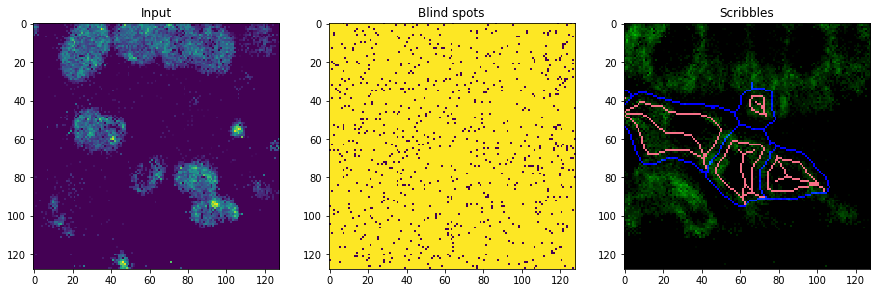

Task 1


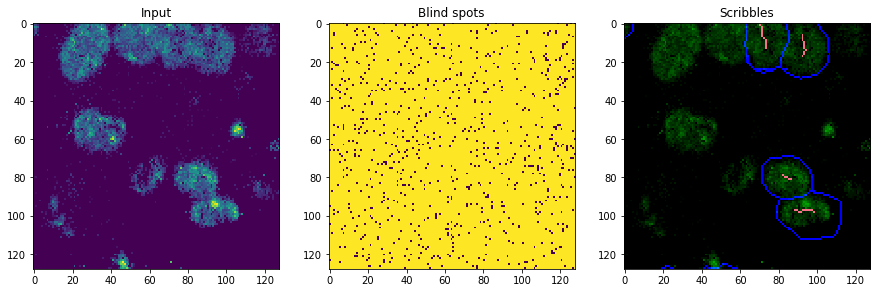

0


In [23]:
## Visualize for reference
from general.utils import to_np
import seaborn as sns
color_list = sns.color_palette("husl", 9) #to color foreground scribbles

for batch, data in enumerate(dataloader_train):
    x = to_np(data['input']).transpose((0, 2, 3, 1))
    target = to_np(data['target']).transpose((0, 2, 3, 1))
    mask = to_np(data['mask']).transpose((0, 2, 3, 1))
    scribble = to_np(data['scribble']).transpose((0, 2, 3, 1))
    for item in np.arange(x.shape[0]):
        ix = 0
        for task in config.classification_tasks:
            classification_task = config.classification_tasks[task]
            nclasses = classification_task['classes']
            print('Task ' + str(task))
            aux = np.zeros([x.shape[1],x.shape[2],3])
            aux[...,1] = x[item,:,:,np.minimum(ix,x.shape[-1]-1)]*0.5
#             aux[...,0] = np.sum(scribble[item,:,:,ix:ix+nclasses]*(np.arange(nclasses)+1)[np.newaxis,np.newaxis,:],axis = -1)#foreground
            aux[...,2] = scribble[item,:,:,ix+nclasses]
            for iclass in range(nclasses):
                aux = aux*(1-scribble[item,:,:,ix+iclass:ix+iclass+1]) + scribble[item,:,:,ix+iclass:ix+iclass+1]*color_list[iclass]
            ix += nclasses + 1
            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.title('Input')
            plt.imshow(x[item,:,:,np.minimum(ix,x.shape[-1]-1)])
            plt.subplot(1,3,2)
            plt.title('Blind spots')
            plt.imshow(mask[item,:,:,np.minimum(ix,x.shape[-1]-1)])
            plt.subplot(1,3,3)
            plt.title('Scribbles')
            plt.imshow(aux)
            plt.show()
        break
    print(batch)
    break

### Network, criteria and optimizer

In [24]:
#------------------------- Network/Optimizer/Criteria --------------------------------#
### Network Unet ###
from general.networks import UNet
model = UNet(config.n_channels,config.n_output,
             depth = config.unet_depth ,
             base = config.unet_base,
             activation = config.activation,
             batchnorm = config.batchnorm)
model = model.to(config.DEVICE)

from general.losses import seglosses, reclosses
criterio_rec = reclosses(type_loss=config.rec_loss, reduction=None)
criterio_seg = seglosses(type_loss=config.seg_loss, reduction=None)

from Impartial.Impartial_functions import compute_impartial_losses
def criterio(out, x, scribble, mask):
    return compute_impartial_losses(out, x, scribble, mask, config, criterio_seg, criterio_rec)

from torch import optim
if config.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE,
                           weight_decay=config.optim_weight_decay)

else:
    if config.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config.LEARNING_RATE,
                                  weight_decay=config.optim_weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=config.LEARNING_RATE)

print('-- Network : ')
print(model)
print()

print('-- Optimizer : ')
print(optimizer)
print()


-- Network : 
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_list): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): ReLU(inplace=True)
          )
        )
      )
    )
    (1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
   

In [25]:
#------------------------- Training --------------------------------#
from general.training import recseg_trainer
history = recseg_trainer(dataloader_train,dataloader_val,model,optimizer,criterio,config)

print(' Saving .... ')
config.save_json()
for key in history.keys():
    history[key] = np.array(history[key]).tolist()

from general.utils import save_json
save_json(history, config.basedir + config.model_name + '/history.json')
print('history file saved on : ', config.basedir + config.model_name + '/history.json')

saving best model, epoch:  0
epoch : 0 | loss mbtr, tr,val : 0.883,0.883,0.796 | seg_fore mbtr, tr,val : 0.983,0.983,0.769 | seg_back mbtr, tr,val : 0.668,0.668,0.539 | rec mbtr, tr,val : 0.94,0.94,0.939 | stop_pat :0
saving best model, epoch:  1
epoch : 1 | loss mbtr, tr,val : 0.791,0.791,0.752 | seg_fore mbtr, tr,val : 0.776,0.776,0.742 | seg_back mbtr, tr,val : 0.52,0.52,0.4 | rec mbtr, tr,val : 0.934,0.934,0.932 | stop_pat :0
saving best model, epoch:  2
epoch : 2 | loss mbtr, tr,val : 0.756,0.756,0.723 | seg_fore mbtr, tr,val : 0.732,0.732,0.539 | seg_back mbtr, tr,val : 0.434,0.434,0.495 | rec mbtr, tr,val : 0.93,0.93,0.928 | stop_pat :0
saving best model, epoch:  3
epoch : 3 | loss mbtr, tr,val : 0.717,0.717,0.679 | seg_fore mbtr, tr,val : 0.602,0.602,0.492 | seg_back mbtr, tr,val : 0.407,0.407,0.363 | rec mbtr, tr,val : 0.929,0.929,0.93 | stop_pat :0
saving best model, epoch:  4
epoch : 4 | loss mbtr, tr,val : 0.685,0.685,0.662 | seg_fore mbtr, tr,val : 0.489,0.489,0.503 | seg_

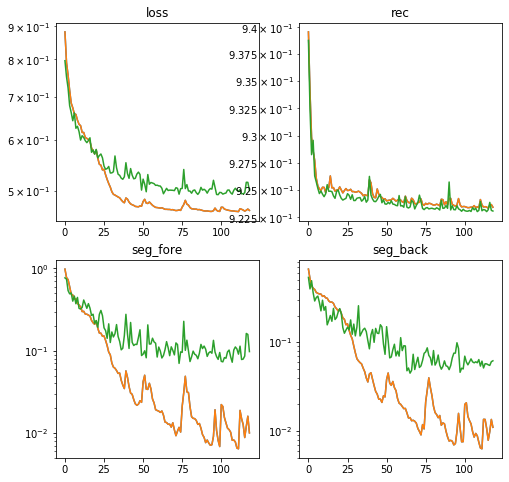

In [26]:
tag = 'loss'
plt.figure(figsize=(8,8))
ix = 1
for tag in ['loss','rec','seg_fore','seg_back']:
    plt.subplot(2,2,ix)
    ix += 1
    plt.title(tag)
    plt.semilogy(history[tag+'_mbatch_train'])
    plt.semilogy(history[tag+'_train'])
    plt.semilogy(history[tag+'_val'])
plt.show()

### Evaluate and compute performance

In [27]:
#------------------------- Evaluation --------------------------------#

from Impartial.Impartial_functions import get_impartial_outputs
from general.evaluation import get_performance
import pickle
saveout = True

th_list = np.linspace(0,1,21)[1:-1]
pd_rows = []
pd_saves_out = []
ix_file = -1
for batch, data in enumerate(dataloader_eval):
    print(batch)
    Xinput = data['input'].to(config.DEVICE)

    model.eval()
    out = model(Xinput)
    output = get_impartial_outputs(out, config) #output has keys: class_segmentation, factors

    Ylabels = data['label'].numpy()
    X = data['input'].numpy()

    if saveout:
        ## Save optional
        save_output_dic = config.basedir + config.model_name + '/output_images/'
        file_output_save = 'eval_batch' + str(batch) + '.pickle'
        mkdir(save_output_dic)
        with open(save_output_dic + file_output_save, 'wb') as handle:
            pickle.dump(output, handle)
    
    for i in np.arange(X.shape[0]):
        ix_file += 1
        print('Evaluation on sample :', i)
        if saveout:
            pd_saves_out.append([pd_files.iloc[ix_file]['prefix'], file_output_save, batch, i])
        
        ix_labels = 0
        for task in config.classification_tasks.keys():
            output_task = output[task]
            for ix_class in range(config.classification_tasks[task]['classes']):

                Ypred_fore = output_task['class_segmentation'][i, int(ix_class), ...]
                
                Ypred_back = 1 - Ypred_fore  # one vs all evaluation
                #                 Y_fore_save.append(Ypred_fore)

                Ylabel = Ylabels[i, ix_labels, ...].astype('int')
                ix_labels += 1
                for th in th_list:
                    rows = [_ for _ in pd_files.iloc[ix_file].values]
                    rows.append(task)
                    rows.append(ix_class)
                    rows.append(th)
                    metrics = get_performance(Ylabel, Ypred_fore, threshold=th)
                    for key in metrics.keys():
                        rows.append(metrics[key])
                    pd_rows.append(rows)


0
Segmentation :
Segmentation :
Segmentation :
Segmentation :


In [28]:
columns = list(pd_files.columns)
columns.extend(['task','segclass', 'th'])
for key in metrics.keys():
    columns.append(key)
pd_summary = pd.DataFrame(data=pd_rows, columns=columns)
pd_summary.to_csv(config.basedir + config.model_name + '/pd_summary_results.csv', index=0)
print('Evaluation csv saved on : ',
      config.basedir + config.model_name + '/pd_summary_results.csv')

if saveout:
    pd_saves = pd.DataFrame(data=pd_saves_out,
                            columns=['prefix', 'output_file', 'batch', 'index'])
    pd_saves.to_csv(save_output_dic + 'pd_output_saves.csv', index=0)
    print('output saves...')


Evaluation csv saved on :  /data/natalia/models/Impartial/MIBI2CH_2tasks/pd_summary_results.csv
output saves...


### Summary Performance

In [4]:
from general.utils import load_json
config_json = load_json(basedir + model_name + '/config.json')
pd_summary = pd.read_csv(config_json['basedir'] + config_json['model_name'] + '/pd_summary_results.csv')

In [5]:
from general.evaluation import summary_performance

pd_best = summary_performance(pd_summary, best_all = False, metric = 'AP', group = 'train')
pd_best_all = summary_performance(pd_summary, best_all = True)

print('Model selection based on AP on training : ')
print(pd_best.groupby(['task','segclass','group']).mean())
print()
print('Best of all Model selection: ')
print(pd_best_all.groupby(['task','segclass','group']).mean())

Model selection based on AP on training : 
                       th       auc      Jacc      mIoU     mDice        AP
task segclass group                                                        
0    0        test   0.65  0.969566  0.629588  0.450607  0.584020  0.204082
              train  0.65  0.953375  0.672811  0.553831  0.677095  0.375518
1    0        test   0.10  0.970402  0.656839  0.632752  0.761889  0.500000
              train  0.10  0.958511  0.674556  0.661234  0.784794  0.623084
     1        test   0.50  0.988296  0.595643  0.493917  0.622281  0.333333
              train  0.50  0.976825  0.582523  0.592223  0.721506  0.471606

Best of all Model selection: 
                       th       auc      Jacc      mIoU     mDice        AP
task segclass group                                                        
0    0        test   0.95  0.969566  0.669207  0.516998  0.658246  0.260870
              train  0.95  0.953375  0.717439  0.560504  0.686405  0.405220
1    0        

### Visualize some of the masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image0.npz train
Task :  0


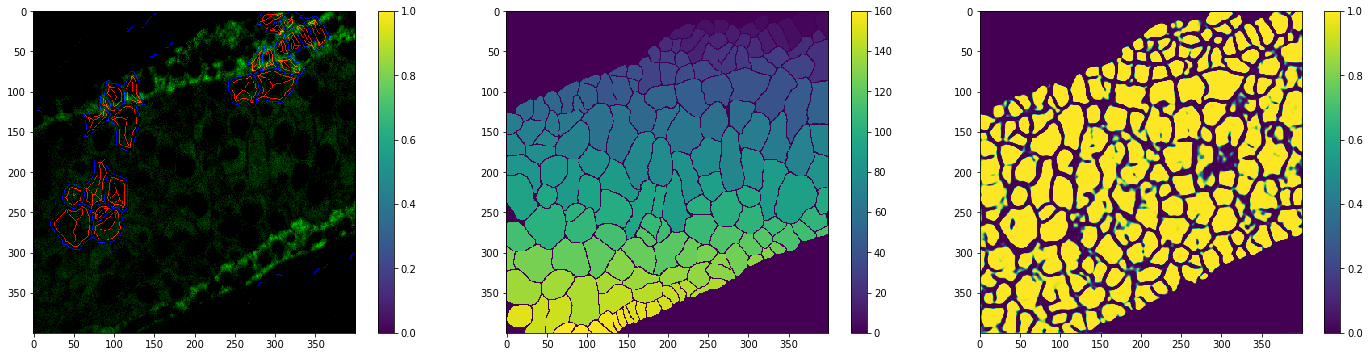

Task :  1


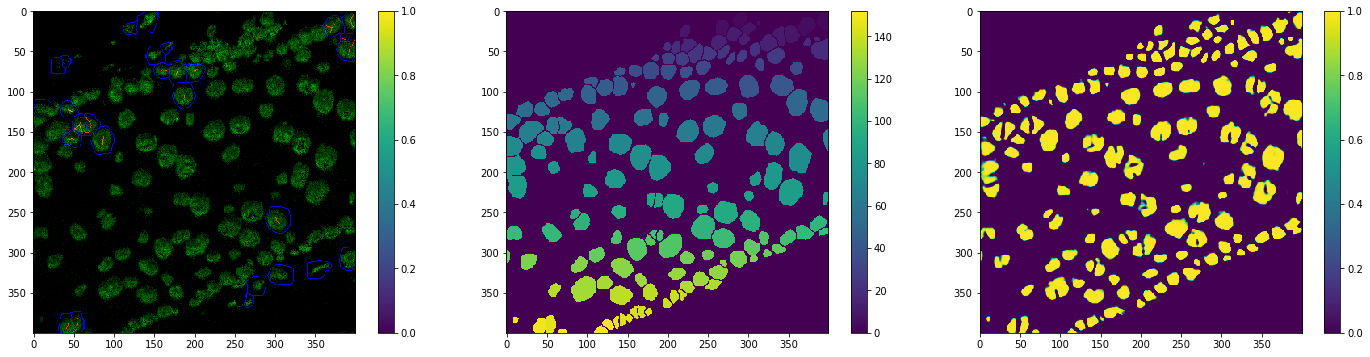

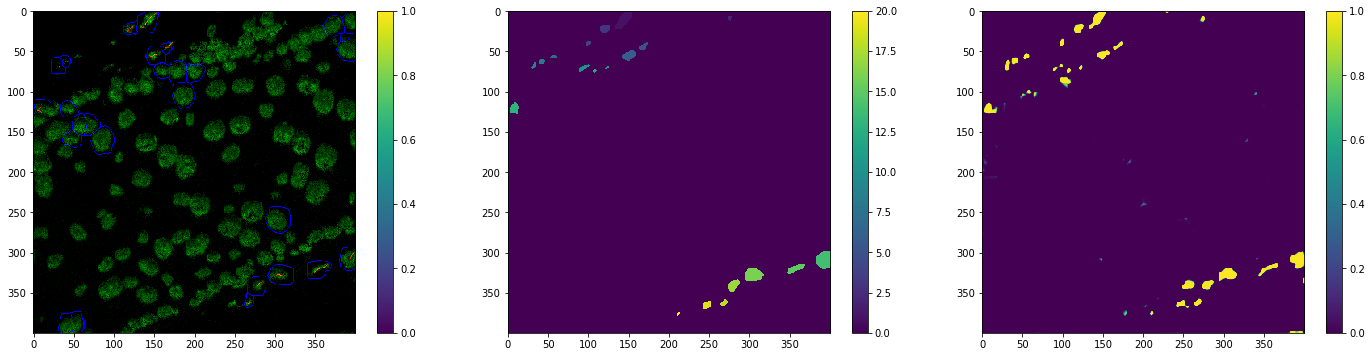

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image1.npz train
Task :  0


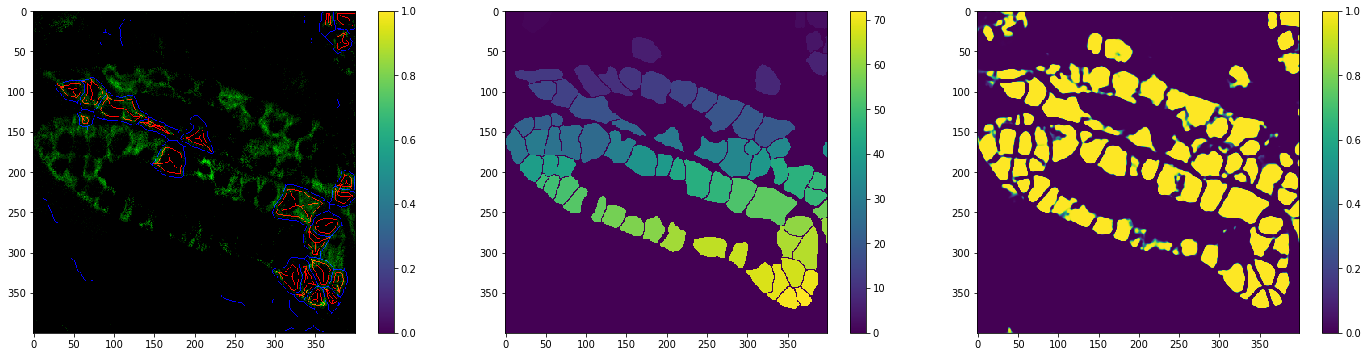

Task :  1


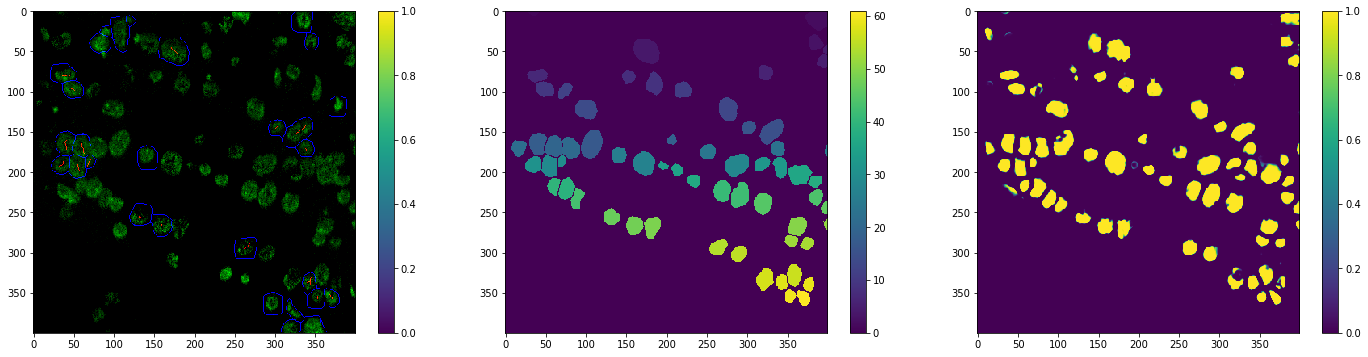

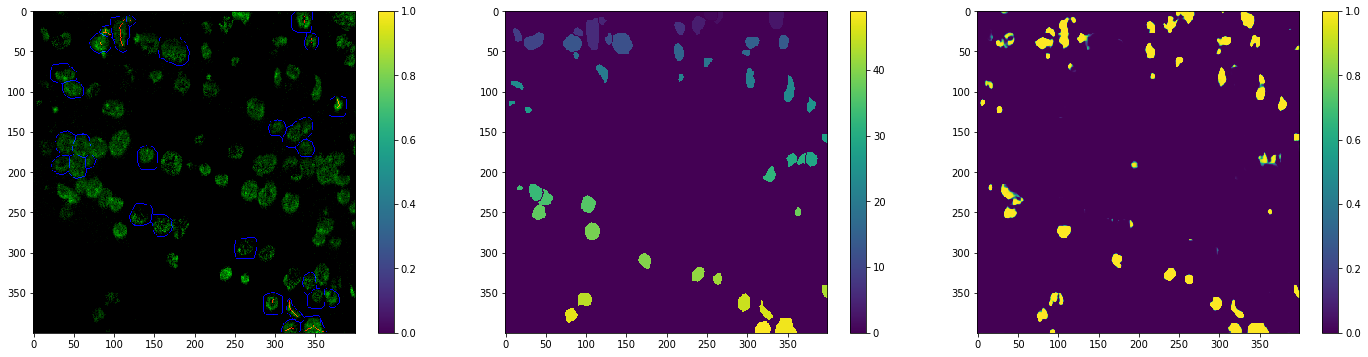


image2.npz test
Task :  0


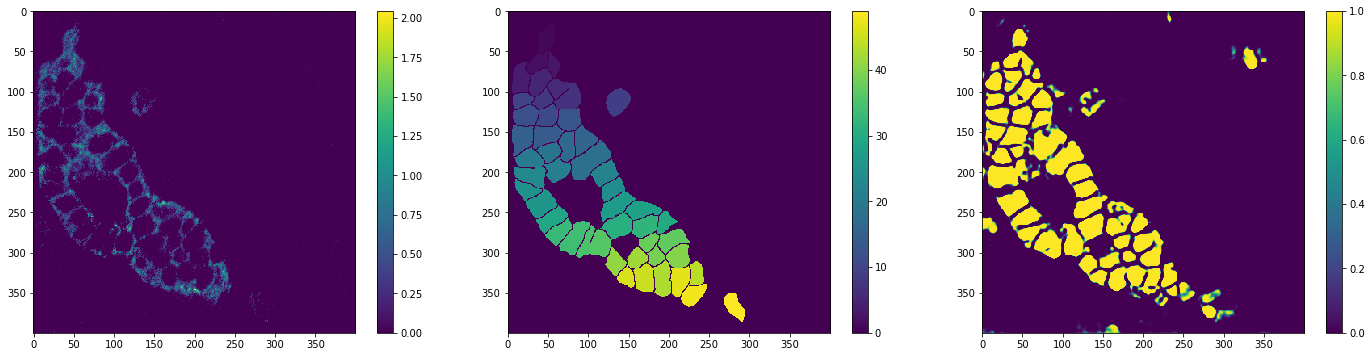

Task :  1


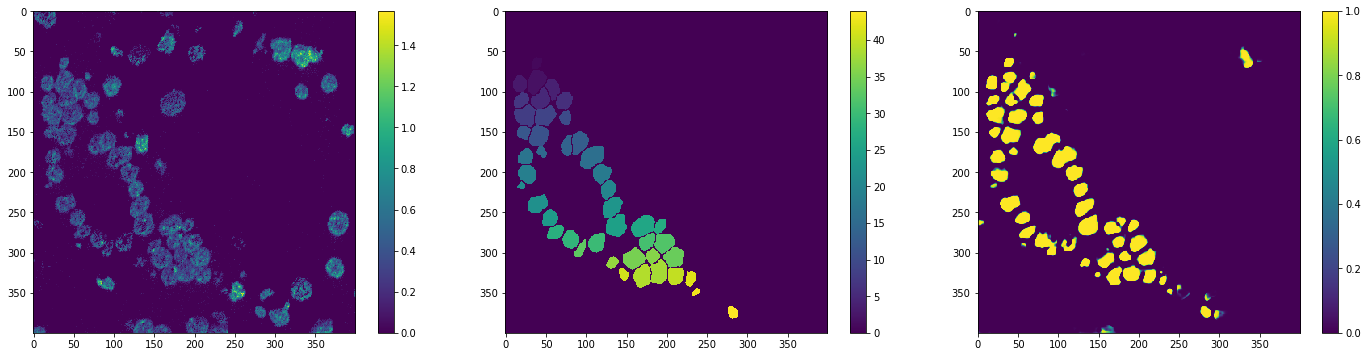

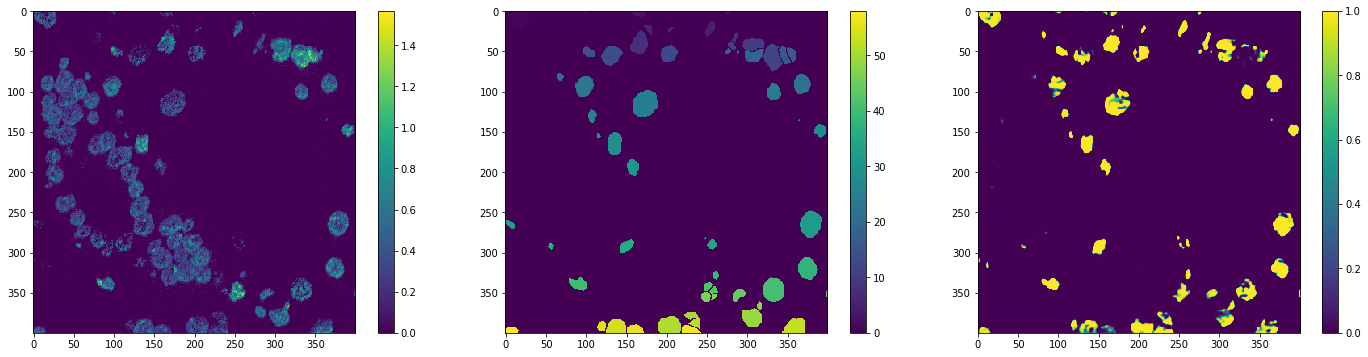

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image3.npz train
Task :  0


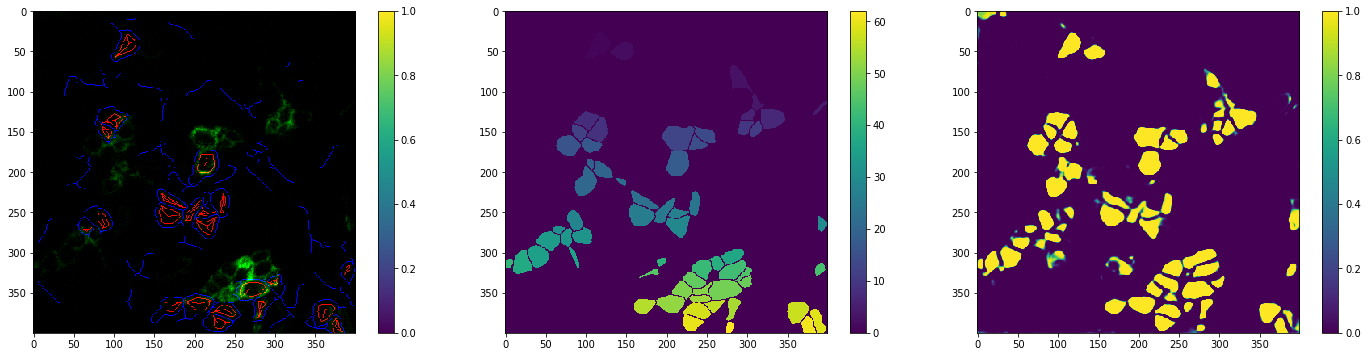

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Task :  1


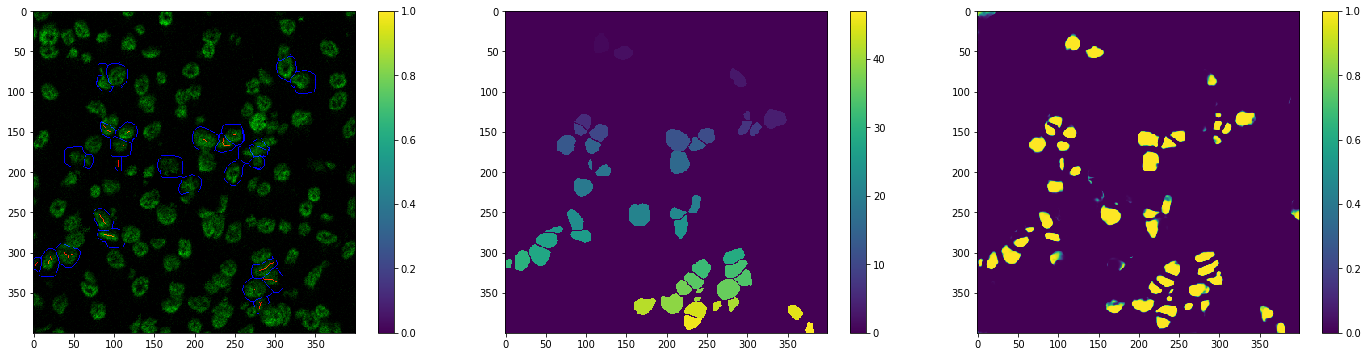

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


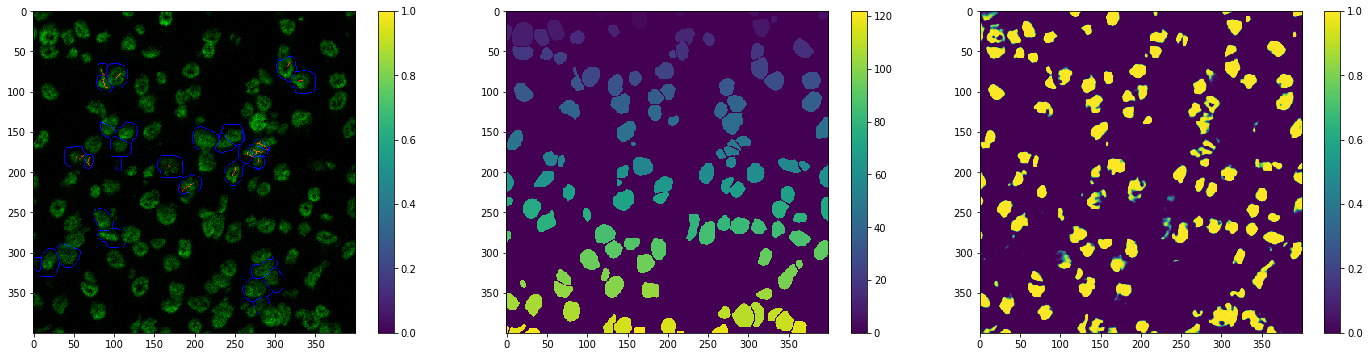

In [6]:
save_output_dic = config_json['basedir'] + config_json['model_name'] + '/output_images/'
pd_out = pd.read_csv(save_output_dic + 'pd_output_saves.csv')

for ix_file in range(len(pd_files)):
    print()
    print(pd_files['input_file'][ix_file],pd_files['group'][ix_file] )
    npz_read = np.load(pd_files['input_dir'][ix_file] + pd_files['input_file'][ix_file])
    image = npz_read['image']
    label = npz_read['label']
    
    index = pd_out['index'][ix_file]
    filename = basedir+model_name+'/output_images/'+pd_out['output_file'][ix_file]
    with open(filename, 'rb') as handle:
        output = pickle.load(handle)
    
    if pd_files['group'][ix_file] == 'train':
        pd_scribble = pd_files_scribbles.loc[pd_files_scribbles['prefix'] == pd_files['prefix'][ix_file]]
        npz_read = np.load(pd_scribble['input_dir'].values[0] + pd_scribble['scribble_file'].values[0])
        scribble = npz_read['scribble']

    ix_scribbles = 0
    for task in output.keys():
        print('Task : ',task)
        # get list of corresponding gt indexes to plot
        ix_labels_list = config_json['classification_tasks'][task]['ix_gt_labels']
        rec_channels = config_json['classification_tasks'][task]['rec_channels']
        nclasses = output[task]['class_segmentation'].shape[1]
        for ix_class in range(nclasses):
            
            ix_labels = int(ix_labels_list[ix_class])
            plt.figure(figsize=(20,5))
            plt.subplot(1,3,1)
            
            if pd_files['group'][ix_file] == 'train':
                aux = np.zeros([image.shape[0],image.shape[1],3])
                aux[...,1] = image[...,rec_channels[0]]*0.6
                aux[...,0] = aux[...,0]*(1-scribble[...,ix_scribbles+ix_class]) + scribble[...,ix_scribbles+ix_class]
                aux[...,2] = scribble[...,ix_scribbles+nclasses]
                plt.imshow(aux)
            else:
                plt.imshow(image[...,rec_channels[0]])
            plt.colorbar()

            plt.subplot(1,3,2)
            plt.imshow(label[...,ix_labels])
            ix_labels += 1
            plt.colorbar()

            plt.subplot(1,3,3)
            plt.imshow((output[task]['class_segmentation'][index,ix_class,...]))
            plt.colorbar()

#             plt.subplot(1,4,4)
#             plt.imshow(1-(output[task]['class_segmentation'][index,ix_class,...]))
#             plt.colorbar()

            plt.tight_layout()
            plt.show()
        
        ix_scribbles += nclasses + 1
